# CS 440/540 Machine Learning in Finance: Homework 4

Download data files from LMS. Code/Explain your solution over this `IPython` notebook at required cells, and complete locally.

To submit your assignment, in LMS, upload your solution to LMS as a single notebook with following file name format:

`lastName_firstName_CourseNumber_HW4.ipynb`

where `CourseNumber` is the course in which you're enrolled (CS 440 or CS 540).

Problems on homework assignments are equally weighted.

Any type of plagiarism will not be tolerated. Your submitted codes will be compared with other submissions and also the codes available on internet and violations will have a penalty of -100 points. (In case of copying from
another student both parties will get -100)

Import all libraries here

In [2]:
#Import libraries before starting
import numpy as np
import pandas as pd
import yfinance as yf
import talib
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader

## Problem 1: Combining Technical Analysis Indicators with 2D CNN on Bitcoin Direction Prediction

In this problem, we will focus on adding technical analysis indicators to original series, which will help us convert it into 2D Image. We will use the following technical indicators from TA-Lib library in Python: MACD, RSI, CMO, MOM, Bollinger Bands, SMA. In general, technical analysis indicators are financial indicators which give trades a guidance about the market. We will use AAPL close prices by downloading via yfinance library. Our train period is 2021-2022 and test period will be 2022-2023.

We will use historical 6 days closing price, build up 6x6 image by calculating technical indicators, and predict the direction for the next day (whether the price will be up or down). We will use a single convolutional layer followed by Fully Connected Layer where kernel size=(2,2) can be set. 

In [5]:
def download_data():
    btc = yf.download('BTC-USD', start='2021-01-01', end='2023-12-31')
    return btc['Close']

In [6]:
prices = download_data()

[*********************100%***********************]  1 of 1 completed


In [7]:
prices.head()

Date
2021-01-01    29374.152344
2021-01-02    32127.267578
2021-01-03    32782.023438
2021-01-04    31971.914062
2021-01-05    33992.429688
Name: Close, dtype: float64

In [8]:
def calculate_indicators(prices):
    df = pd.DataFrame()
    
    # MACD
    macd, macdsignal, macdhist = talib.MACD(prices)
    df['MACD'] = macd
    
    # RSI
    df['RSI'] = talib.RSI(prices)
    
    # CMO (Chande Momentum Oscillator)
    df['CMO'] = talib.CMO(prices)
    
    # MOM (Momentum)
    df['MOM'] = talib.MOM(prices)
    
    # Bollinger Bands
    upper, middle, lower = talib.BBANDS(prices)
    df['BB_upper'] = upper
    df['BB_middle'] = middle
    df['BB_lower'] = lower
    
    # SMA
    df['SMA'] = talib.SMA(prices)
    
    return df

In [9]:
indicators = calculate_indicators(prices)

In [10]:
indicators.head()

,MACD,RSI,CMO,MOM,BB_upper,BB_middle,BB_lower,SMA
Date,,,,,,,,
2021-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-05,NaN,NaN,NaN,NaN,35080.216597,32049.557422,29018.898247,NaN


In [11]:
indicators = indicators.dropna()

In [12]:
indicators.head()

,MACD,RSI,CMO,MOM,BB_upper,BB_middle,BB_lower,SMA
Date,,,,,,,,
2021-02-03,-226.422720,62.098634,24.197269,5182.710938,37925.235102,34780.687500,31636.139898,35262.511523
2021-02-04,-15.039748,60.319527,20.639054,4559.673828,38809.440003,35311.996094,31814.552184,35360.299414
2021-02-05,247.926798,62.875123,25.750246,5574.458984,39594.868785,36317.985938,33041.103090,35404.297591
2021-02-06,540.609933,65.103681,30.207362,8833.464844,39964.391465,37463.753125,34963.114785,35400.796549
2021-02-07,734.836297,63.771135,27.542271,5437.343750,39879.156250,38142.383594,36405.610937,35337.657617


In [13]:
prices = prices[indicators.index]

In [14]:
prices.shape

(1061,)

In [15]:
train_end = '2022-12-31'
train_indicators = indicators[:train_end]
train_prices = prices[:train_end]

In [18]:
def create_2d_images(indicators, prices, lookback=6):
    images = []
    labels = []
    
    # MACD, RSI, CMO, MOM, BB_upper, BB_middle, BB_lower, SMA (BB is not a single indicator)
    # Total number of indicators different than the image size, we need to resize
    
    scaler = MinMaxScaler() # normalize all indicators
    normalized_indicators = scaler.fit_transform(indicators)
    normalized_indicators = pd.DataFrame(normalized_indicators, columns=indicators.columns)
    
    # adding two additional columns for square
    normalized_indicators['padding1'] = 0
    normalized_indicators['padding2'] = 0
    
    for i in range(lookback, len(indicators)-1):
        img = np.zeros((6, 6))
        
        window_data = normalized_indicators.iloc[i-lookback+1:i+1].values  # 6 days for the data
        
        for j in range(6):  # For each day
            # First 6 indicators
            img[j, :6] = window_data[j, :6]
            
        images.append(img)
        
        #labels based on upper or down
        label = 1 if prices.iloc[i+1] > prices.iloc[i] else 0
        labels.append(label)
    
    return np.array(images), np.array(labels)


In [19]:
train_images, train_labels = create_2d_images(train_indicators, train_prices)

In [20]:
print("Image shape:", train_images.shape)
print("Number of labels:", len(train_labels))

Image shape: (690, 6, 6)
Number of labels: 690


In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_technical_images(images, labels, num_samples=5):
    
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 4))
    
    for i in range(num_samples):
        sns.heatmap(images[i], 
                   ax=axes[i],
                   cmap='YlOrRd', 
                   xticklabels=False,
                   yticklabels=False,
                   cbar=True)
        
        direction = "UP" if labels[i] == 1 else "DOWN"
        axes[i].set_title(f'Next Day: {direction}')
    
    plt.tight_layout()
    plt.show()

    print("\nDetailed values for the first image:")
    print(images[0])

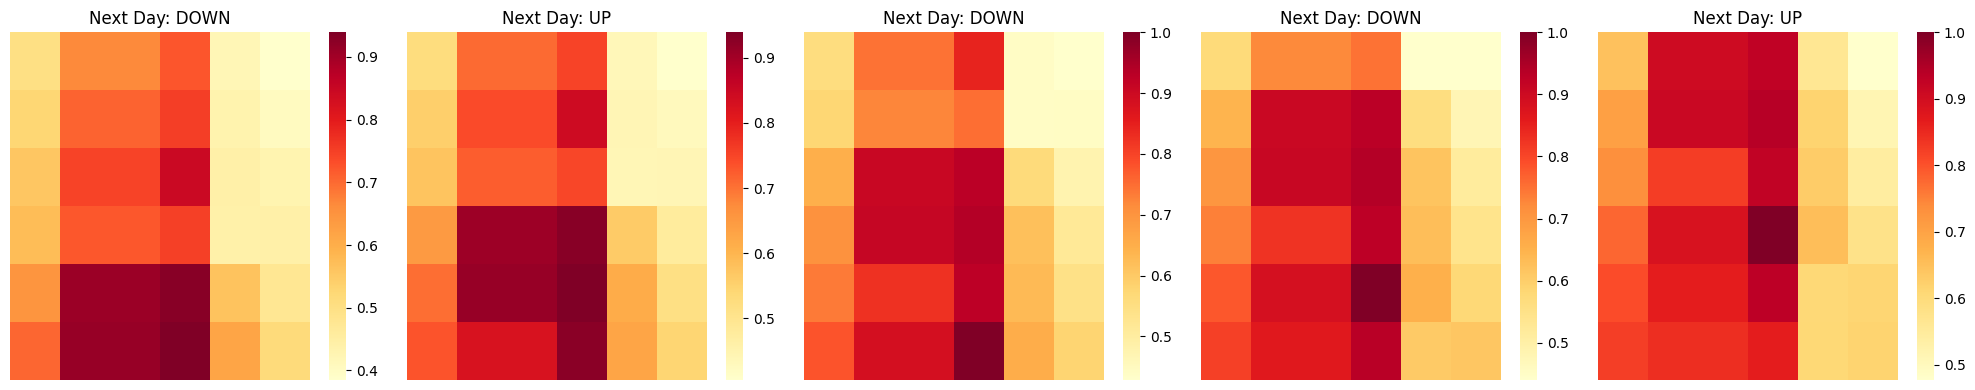


Detailed values for the first image:
[[0.50072243 0.66535758 0.66535758 0.7243842  0.41957637 0.38468023]
 [0.52685595 0.70772397 0.70772397 0.75288777 0.43443305 0.40503156]
 [0.5559427  0.74466876 0.74466876 0.84442766 0.4414227  0.42821062]
 [0.57524484 0.72257797 0.72257797 0.74903644 0.43981045 0.44193942]
 [0.64735243 0.9070709  0.9070709  0.9300018  0.56309269 0.47723852]
 [0.70444956 0.91237488 0.91237488 0.93931318 0.61706996 0.51589851]]


In [22]:
plot_technical_images(train_images, train_labels)


Consecutive days visualization:


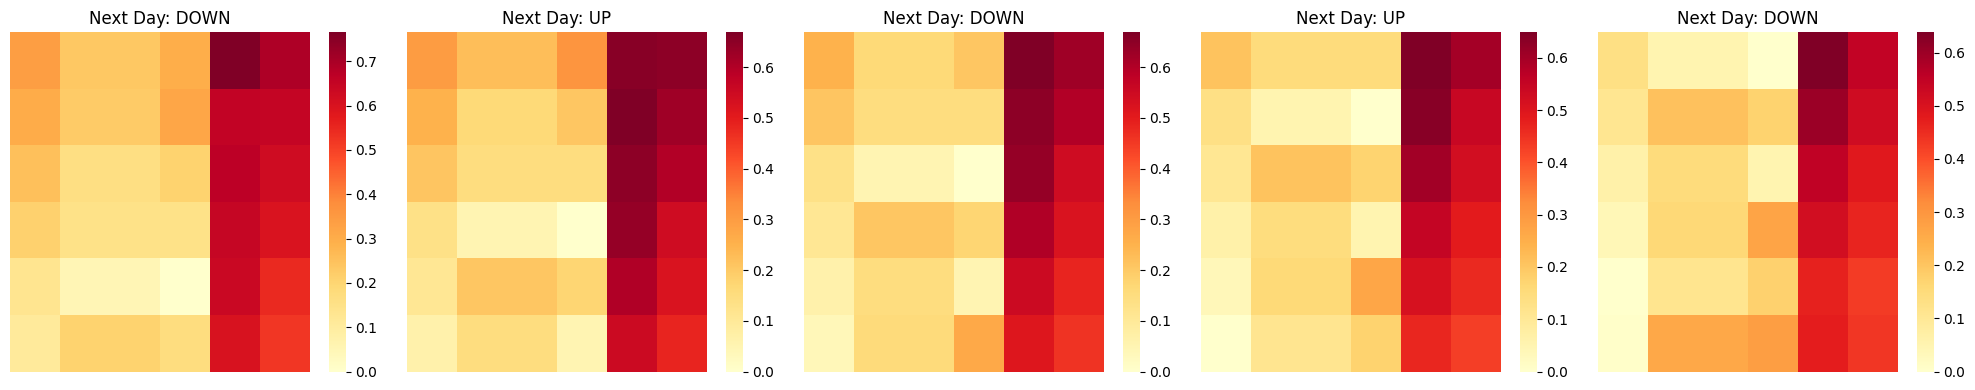


Detailed values for the first image:
[[0.34022819 0.23333834 0.23333834 0.29678236 0.76541378 0.69077081]
 [0.30217179 0.22636206 0.22636206 0.31710039 0.65684516 0.64930499]
 [0.25149782 0.16317215 0.16317215 0.20816184 0.66857962 0.62659452]
 [0.20967372 0.1505071  0.1505071  0.14986504 0.6486936  0.59905403]
 [0.13341064 0.05111362 0.05111362 0.         0.63814025 0.54694885]
 [0.10783242 0.20851167 0.20851167 0.17282206 0.60145372 0.5227639 ]]


In [23]:
print("\nConsecutive days visualization:")
plot_technical_images(train_images[100:105], train_labels[100:105])

In [24]:
class BTCDataset(Dataset):
    def __init__(self, images, labels):
        self.images = torch.FloatTensor(images)
        self.labels = torch.LongTensor(labels)
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        return self.images[idx].unsqueeze(0), self.labels[idx]

In [25]:
train_dataset = BTCDataset(train_images, train_labels)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [26]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=2)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16 * 5 * 5, 2)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.flatten(x)
        x = self.fc1(x)
        return x

In [50]:
def train_model(train_loader,model,criterion,optimizer,num_epochs=50):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        correct = 0
        total = 0
        for images,labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            total_loss += loss.item()
            
        accuracy = 100 * correct / total
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}, Accuracy: {accuracy:.2f}%')

In [51]:
model = CNNModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [52]:
train_model(train_loader, model, criterion, optimizer)

Epoch [1/50], Loss: 0.6995, Accuracy: 49.71%
Epoch [2/50], Loss: 0.6951, Accuracy: 49.13%
Epoch [3/50], Loss: 0.6929, Accuracy: 51.16%
Epoch [4/50], Loss: 0.6932, Accuracy: 50.72%
Epoch [5/50], Loss: 0.6920, Accuracy: 52.46%
Epoch [6/50], Loss: 0.6916, Accuracy: 52.90%
Epoch [7/50], Loss: 0.6935, Accuracy: 50.87%
Epoch [8/50], Loss: 0.6921, Accuracy: 51.01%
Epoch [9/50], Loss: 0.6898, Accuracy: 53.19%
Epoch [10/50], Loss: 0.6912, Accuracy: 53.19%
Epoch [11/50], Loss: 0.6921, Accuracy: 51.59%
Epoch [12/50], Loss: 0.6907, Accuracy: 54.20%
Epoch [13/50], Loss: 0.6936, Accuracy: 51.01%
Epoch [14/50], Loss: 0.6883, Accuracy: 53.33%
Epoch [15/50], Loss: 0.6885, Accuracy: 53.33%
Epoch [16/50], Loss: 0.6872, Accuracy: 52.75%
Epoch [17/50], Loss: 0.6887, Accuracy: 53.33%
Epoch [18/50], Loss: 0.6866, Accuracy: 52.32%
Epoch [19/50], Loss: 0.6873, Accuracy: 51.88%
Epoch [20/50], Loss: 0.6868, Accuracy: 54.93%
Epoch [21/50], Loss: 0.6858, Accuracy: 53.04%
Epoch [22/50], Loss: 0.6855, Accuracy: 53.9

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [54]:
test_indicators = indicators['2023-01-01':]  
test_prices = prices['2023-01-01':]

test_images, test_labels = create_2d_images(test_indicators, test_prices)

test_dataset = BTCDataset(test_images, test_labels)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [56]:
def predict(model, test_loader):
    model.eval()  # evaluation mode for test predictions
    predictions = []
    actual = []
    
    with torch.no_grad(): 
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            predictions.extend(predicted.numpy())
            actual.extend(labels.numpy())
    
    return np.array(predictions), np.array(actual)

# predictions
predictions, actual = predict(model, test_loader)

In [57]:
predictions, actual = predict(model, test_loader)

In [58]:
accuracy = accuracy_score(actual, predictions)
print(f"Test Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(actual, predictions, target_names=['Down', 'Up']))

Test Accuracy: 0.5098

Classification Report:
              precision    recall  f1-score   support

        Down       0.51      0.94      0.66       181
          Up       0.52      0.06      0.11       176

    accuracy                           0.51       357
   macro avg       0.52      0.50      0.39       357
weighted avg       0.52      0.51      0.39       357



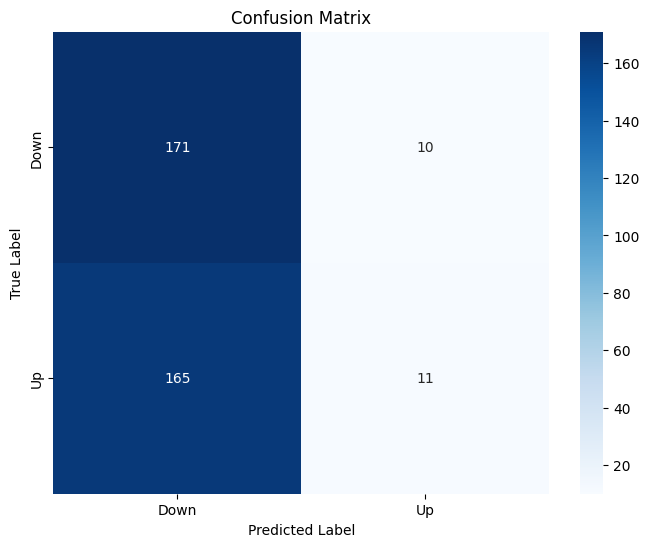

In [59]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(actual, predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Down', 'Up'],
            yticklabels=['Down', 'Up'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [60]:
print("\nSample predictions:")
print("Predicted\tActual")
print("-" * 30)
for i in range(10):  
    print(f"{'Up' if predictions[i] == 1 else 'Down'}\t\t{'Up' if actual[i] == 1 else 'Down'}")


Sample predictions:
Predicted	Actual
------------------------------
Down		Up
Down		Up
Down		Up
Down		Up
Down		Up
Down		Up
Down		Up
Down		Down
Down		Up
Down		Down


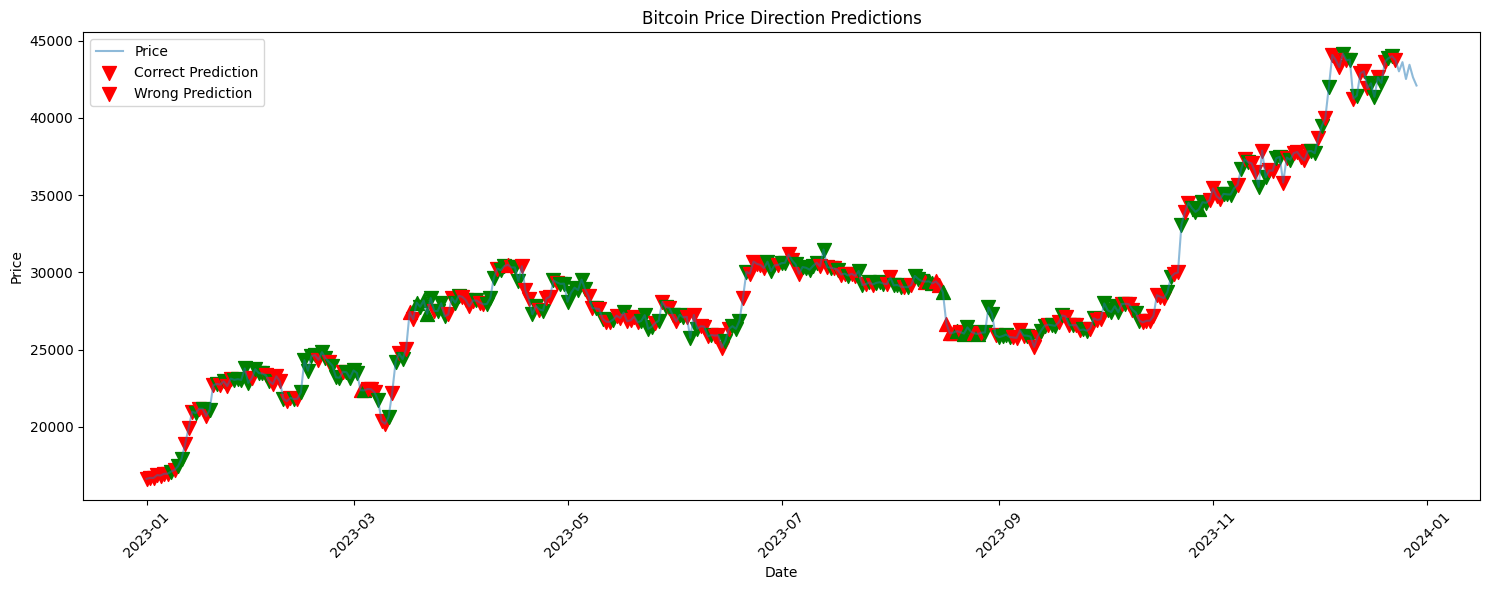

In [61]:
plt.figure(figsize=(15, 6))
plt.plot(test_prices.index[:-1], test_prices[:-1], label='BTC Price', alpha=0.5)

# Plot predictions
for i, (pred, act) in enumerate(zip(predictions, actual)):
    color = 'green' if pred == act else 'red'
    marker = '^' if pred == 1 else 'v'
    plt.scatter(test_prices.index[i], test_prices.iloc[i], 
               color=color, marker=marker, s=100)

plt.title('Bitcoin Price Direction Predictions')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(['Price', 'Correct Prediction', 'Wrong Prediction'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Problem 2: Multivariate LSTM for Predicting EPS (Earnings per Share) over Company Fundamentals

In this problem, we will focus on predicting Earnings Per Share (EPS) by jointly modeling historical fundamentals where fundamentals for multiple companies in "fundamentals.csv" file for each year. Number of latent dimension of LSTM can be [5, 10, 30] and the best one can be determined by hyperparameter search. On the other hand, learning rate and number of epochs should be carefully tuned. Our evaluation metric will be MAPE score

In [62]:
df = pd.read_csv('fundamentals.csv')

In [64]:
print("Dataset Shape:", df.shape)

Dataset Shape: (1781, 79)


In [66]:
print("\nFirst few rows:")
print(df.head())


First few rows:
   Unnamed: 0 Ticker Symbol Period Ending  Accounts Payable  \
0           0           AAL    2012-12-31      3.068000e+09   
1           1           AAL    2013-12-31      4.975000e+09   
2           2           AAL    2014-12-31      4.668000e+09   
3           3           AAL    2015-12-31      5.102000e+09   
4           4           AAP    2012-12-29      2.409453e+09   

   Accounts Receivable  Add'l income/expense items  After Tax ROE  \
0         -222000000.0               -1.961000e+09           23.0   
1          -93000000.0               -2.723000e+09           67.0   
2         -160000000.0               -1.500000e+08          143.0   
3          352000000.0               -7.080000e+08          135.0   
4          -89482000.0                6.000000e+05           32.0   

   Capital Expenditures  Capital Surplus  Cash Ratio  ...  \
0         -1.888000e+09     4.695000e+09        53.0  ...   
1         -3.114000e+09     1.059200e+10        75.0  ...   
2     

In [67]:
print("\nColumns:")
print(df.columns.tolist())


Columns:
['Unnamed: 0', 'Ticker Symbol', 'Period Ending', 'Accounts Payable', 'Accounts Receivable', "Add'l income/expense items", 'After Tax ROE', 'Capital Expenditures', 'Capital Surplus', 'Cash Ratio', 'Cash and Cash Equivalents', 'Changes in Inventories', 'Common Stocks', 'Cost of Revenue', 'Current Ratio', 'Deferred Asset Charges', 'Deferred Liability Charges', 'Depreciation', 'Earnings Before Interest and Tax', 'Earnings Before Tax', 'Effect of Exchange Rate', 'Equity Earnings/Loss Unconsolidated Subsidiary', 'Fixed Assets', 'Goodwill', 'Gross Margin', 'Gross Profit', 'Income Tax', 'Intangible Assets', 'Interest Expense', 'Inventory', 'Investments', 'Liabilities', 'Long-Term Debt', 'Long-Term Investments', 'Minority Interest', 'Misc. Stocks', 'Net Borrowings', 'Net Cash Flow', 'Net Cash Flow-Operating', 'Net Cash Flows-Financing', 'Net Cash Flows-Investing', 'Net Income', 'Net Income Adjustments', 'Net Income Applicable to Common Shareholders', 'Net Income-Cont. Operations', 'Ne

In [74]:
from sklearn.preprocessing import StandardScaler

def prepare_data(df, sequence_length=3):
    df_copy = df.copy()
    
    df_copy['Period Ending'] = pd.to_datetime(df_copy['Period Ending'])
    
    ticker_encoding = {ticker: idx for idx, ticker in enumerate(df_copy['Ticker Symbol'].unique())}
    df_copy['Ticker_encoded'] = df_copy['Ticker Symbol'].map(ticker_encoding)
    
    columns_to_drop = ['Unnamed: 0', 'Ticker Symbol', 'Period Ending']
    df_copy = df_copy.drop(columns=columns_to_drop)
    
    target_column = 'Earnings Per Share'
    
    features = df_copy.drop(target_column, axis=1)
    target = df_copy[target_column]
    
    for col in features.columns:
        features[col] = pd.to_numeric(features[col], errors='coerce')
    
    features = features.fillna(features.mean())
    target = target.fillna(target.mean())
    
    print("Features shape:", features.shape)
    print("Number of unique companies:", len(ticker_encoding))
    
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    
    features_scaled = scaler_X.fit_transform(features)
    target_scaled = scaler_y.fit_transform(target.values.reshape(-1, 1))
    
    X, y = [], []
    
    for ticker in ticker_encoding.keys():
        ticker_indices = df_copy['Ticker_encoded'] == ticker_encoding[ticker]
        company_features = features_scaled[ticker_indices]
        company_target = target_scaled[ticker_indices]
        
        for i in range(len(company_features) - sequence_length):
            X.append(company_features[i:(i + sequence_length)])
            y.append(company_target[i + sequence_length])
    
    return np.array(X), np.array(y), scaler_X, scaler_y, ticker_encoding


In [107]:
def prepare_data_remove_outliers(df, sequence_length=3):
    df_copy = df.copy()
    
    df_copy['Period Ending'] = pd.to_datetime(df_copy['Period Ending'])
    
    ticker_encoding = {ticker: idx for idx, ticker in enumerate(df_copy['Ticker Symbol'].unique())}
    df_copy['Ticker_encoded'] = df_copy['Ticker Symbol'].map(ticker_encoding)
    
    columns_to_drop = ['Unnamed: 0', 'Ticker Symbol', 'Period Ending']
    df_copy = df_copy.drop(columns=columns_to_drop)
    
    target_column = 'Earnings Per Share'
    
    # remove outliers because MAPE value is too high
    Q1 = df_copy[target_column].quantile(0.25)
    Q3 = df_copy[target_column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    df_copy[target_column] = df_copy[target_column].clip(lower_bound, upper_bound)
    
    features = df_copy.drop(target_column, axis=1)
    target = df_copy[target_column]
    
    for col in features.columns:
        features[col] = pd.to_numeric(features[col], errors='coerce')
    
    features = features.fillna(features.mean())
    target = target.fillna(target.mean())
    
    from sklearn.preprocessing import RobustScaler
    scaler_X = RobustScaler()
    scaler_y = RobustScaler()
    
    features_scaled = scaler_X.fit_transform(features)
    target_scaled = scaler_y.fit_transform(target.values.reshape(-1, 1))
    
    X, y = [], []
    
    for ticker in ticker_encoding.keys():
        ticker_indices = df_copy['Ticker_encoded'] == ticker_encoding[ticker]
        company_features = features_scaled[ticker_indices]
        company_target = target_scaled[ticker_indices]
        
        for i in range(len(company_features) - sequence_length):
            X.append(company_features[i:(i + sequence_length)])
            y.append(company_target[i + sequence_length])
    
    return np.array(X), np.array(y), scaler_X, scaler_y, ticker_encoding

In [76]:
X, y, scaler_X, scaler_y, ticker_mapping = prepare_data(df)

Features shape: (1781, 76)
Number of unique companies: 448


In [109]:
X, y, scaler_X, scaler_y, ticker_mapping = prepare_data_remove_outliers(df)

print("After new preparation:")
print("X shape:", X.shape)
print("Y range:", np.min(y), "-", np.max(y))
print("X range:", np.min(X), "-", np.max(X))

After new preparation:
X shape: (440, 3, 76)
Y range: -2.4150197628458496 - 2.328063241106719
X range: -340882000.0 - 15010000000.0


In [110]:
# input sequences and their targets
for i in range(3):
    print(f"\nSequence {i}:")
    print("Input sequence shape:", X[i].shape)
    print("Target value:", y[i])

    original_sequence = scaler_X.inverse_transform(X[i])
    original_target = scaler_y.inverse_transform([y[i]])
    print("Original target EPS:", original_target[0])


Sequence 0:
Input sequence shape: (3, 76)
Target value: [2.32806324]
Original target EPS: [9.09]

Sequence 1:
Input sequence shape: (3, 76)
Target value: [1.28458498]
Original target EPS: [6.45]

Sequence 2:
Input sequence shape: (3, 76)
Target value: [2.03557312]
Original target EPS: [8.35]


In [111]:
print("\nPrepared data shapes:")
print("X shape (samples, sequence_length, features):", X.shape)
print("y shape (samples, 1):", y.shape)


Prepared data shapes:
X shape (samples, sequence_length, features): (440, 3, 76)
y shape (samples, 1): (440, 1)


In [112]:
print("Original EPS statistics:")
print(df['Earnings Per Share'].describe())

print("\nScaled data statistics:")
print("X shape:", X.shape)
print("Y range:", np.min(y), "-", np.max(y))

print("\nAny infinite values in X?", np.any(np.isinf(X)))
print("Any NaN values in X?", np.any(np.isnan(X)))
print("X range:", np.min(X), "-", np.max(X))

Original EPS statistics:
count    1562.000000
mean        3.353707
std         4.695896
min       -61.200000
25%         1.590000
50%         2.810000
75%         4.590000
max        50.090000
Name: Earnings Per Share, dtype: float64

Scaled data statistics:
X shape: (440, 3, 76)
Y range: -2.4150197628458496 - 2.328063241106719

Any infinite values in X? False
Any NaN values in X? False
X range: -340882000.0 - 15010000000.0


In [113]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

Training set shape: (308, 3, 76)
Validation set shape: (66, 3, 76)
Test set shape: (66, 3, 76)


In [114]:
class CompanyFundamentalsDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [115]:
train_dataset = CompanyFundamentalsDataset(X_train, y_train)
val_dataset = CompanyFundamentalsDataset(X_val, y_val)
test_dataset = CompanyFundamentalsDataset(X_test, y_test)

In [116]:
from torch.utils.data import Dataset, DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [117]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))

        out = self.fc(out[:, -1, :])
        return out

In [118]:
from sklearn.metrics import mean_absolute_percentage_error

def hyperparameter_search(X_train, y_train, X_val, y_val, input_size):
    hidden_sizes = [5, 10, 30]
    learning_rates = [0.0001, 0.001, 0.005, 0.01]
    best_mape = float('inf')
    best_params = None
    results = []
    
    for hidden_size in hidden_sizes:
        for lr in learning_rates:
            print(f"\nTrying hidden_size={hidden_size}, lr={lr}")
            
            # Create model and datasets
            model = LSTMModel(input_size=input_size, hidden_size=hidden_size)
            train_dataset = CompanyFundamentalsDataset(X_train, y_train)
            val_dataset = CompanyFundamentalsDataset(X_val, y_val)
            train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=16)
            
            criterion = nn.MSELoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        
            best_val_mape = float('inf')
            for epoch in range(200):
                # Training
                model.train()
                for X_batch, y_batch in train_loader:
                    optimizer.zero_grad()
                    outputs = model(X_batch)
                    loss = criterion(outputs, y_batch)
                    loss.backward()
                    optimizer.step()
                
                # Validation
                model.eval()
                val_predictions = []
                val_actuals = []
                with torch.no_grad():
                    for X_batch, y_batch in val_loader:
                        outputs = model(X_batch)
                        val_predictions.extend(outputs.numpy())
                        val_actuals.extend(y_batch.numpy())
            
                val_mape = mean_absolute_percentage_error(val_actuals, val_predictions)
                
                if val_mape < best_val_mape:
                    best_val_mape = val_mape
                
                if epoch % 10 == 0:
                    print(f"Epoch {epoch}, MAPE: {val_mape:.2f}%")
            
            results.append({
                'hidden_size': hidden_size,
                'lr': lr,
                'mape': best_val_mape
            })
            
            if best_val_mape < best_mape:
                best_mape = best_val_mape
                best_params = {'hidden_size': hidden_size, 'lr': lr}
    
    print("\nAll results:")
    for result in sorted(results, key=lambda x: x['mape']):
        print(f"Hidden Size: {result['hidden_size']}, LR: {result['lr']}, MAPE: {result['mape']:.2f}%")
    
    return best_params, best_mape

In [119]:
# hyperparameter search
best_params, best_mape = hyperparameter_search(X_train, y_train, X_val, y_val, X.shape[2])
print(f"\nBest parameters: {best_params}")
print(f"Best validation MAPE: {best_mape:.2f}%")


Trying hidden_size=5, lr=0.0001
Epoch 0, MAPE: 19.53%
Epoch 10, MAPE: 18.87%
Epoch 20, MAPE: 18.33%
Epoch 30, MAPE: 17.95%
Epoch 40, MAPE: 17.73%
Epoch 50, MAPE: 17.68%
Epoch 60, MAPE: 17.57%
Epoch 70, MAPE: 17.56%
Epoch 80, MAPE: 17.48%
Epoch 90, MAPE: 17.57%
Epoch 100, MAPE: 17.58%
Epoch 110, MAPE: 17.69%
Epoch 120, MAPE: 17.84%
Epoch 130, MAPE: 18.28%
Epoch 140, MAPE: 18.55%
Epoch 150, MAPE: 19.36%
Epoch 160, MAPE: 19.89%
Epoch 170, MAPE: 20.53%
Epoch 180, MAPE: 21.23%
Epoch 190, MAPE: 21.83%

Trying hidden_size=5, lr=0.001
Epoch 0, MAPE: 10.64%
Epoch 10, MAPE: 6.82%
Epoch 20, MAPE: 9.10%
Epoch 30, MAPE: 13.36%
Epoch 40, MAPE: 17.42%
Epoch 50, MAPE: 19.78%
Epoch 60, MAPE: 22.69%
Epoch 70, MAPE: 24.29%
Epoch 80, MAPE: 27.44%
Epoch 90, MAPE: 28.05%
Epoch 100, MAPE: 28.39%
Epoch 110, MAPE: 27.81%
Epoch 120, MAPE: 29.27%
Epoch 130, MAPE: 28.63%
Epoch 140, MAPE: 28.87%
Epoch 150, MAPE: 28.55%
Epoch 160, MAPE: 28.12%
Epoch 170, MAPE: 27.31%
Epoch 180, MAPE: 27.06%
Epoch 190, MAPE: 26.23%

In [120]:
final_model = LSTMModel(input_size=X.shape[2], hidden_size=best_params['hidden_size'])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(final_model.parameters(), lr=best_params['lr'])

In [122]:
num_epochs = 400 
best_val_mape = float('inf')
patience_counter = 0
train_losses = []
val_mapes = []

In [124]:

for epoch in range(num_epochs):
    # Training
    final_model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = final_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
    
    # Validation
    final_model.eval()
    val_predictions = []
    val_actuals = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = final_model(X_batch)
            val_predictions.extend(outputs.numpy())
            val_actuals.extend(y_batch.numpy())
    
    val_mape = mean_absolute_percentage_error(val_actuals, val_predictions) 
    val_mapes.append(val_mape)
    
    if (epoch + 1) % 10 == 0: 
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Val MAPE: {val_mape:.2f}%')

Epoch [10/400], Loss: 0.3449, Val MAPE: 50.40%
Epoch [20/400], Loss: 0.3519, Val MAPE: 50.43%
Epoch [30/400], Loss: 0.3341, Val MAPE: 50.49%
Epoch [40/400], Loss: 0.3353, Val MAPE: 50.54%
Epoch [50/400], Loss: 0.3429, Val MAPE: 50.66%
Epoch [60/400], Loss: 0.3479, Val MAPE: 50.89%
Epoch [70/400], Loss: 0.3388, Val MAPE: 50.90%
Epoch [80/400], Loss: 0.3425, Val MAPE: 51.23%
Epoch [90/400], Loss: 0.3507, Val MAPE: 51.12%
Epoch [100/400], Loss: 0.3527, Val MAPE: 50.63%
Epoch [110/400], Loss: 0.3397, Val MAPE: 51.06%
Epoch [120/400], Loss: 0.3381, Val MAPE: 51.20%
Epoch [130/400], Loss: 0.3356, Val MAPE: 51.01%
Epoch [140/400], Loss: 0.3560, Val MAPE: 51.12%
Epoch [150/400], Loss: 0.3379, Val MAPE: 51.00%
Epoch [160/400], Loss: 0.3337, Val MAPE: 51.27%
Epoch [170/400], Loss: 0.3321, Val MAPE: 51.14%
Epoch [180/400], Loss: 0.3361, Val MAPE: 51.52%
Epoch [190/400], Loss: 0.3533, Val MAPE: 51.04%
Epoch [200/400], Loss: 0.3492, Val MAPE: 50.93%
Epoch [210/400], Loss: 0.3497, Val MAPE: 50.91%
E

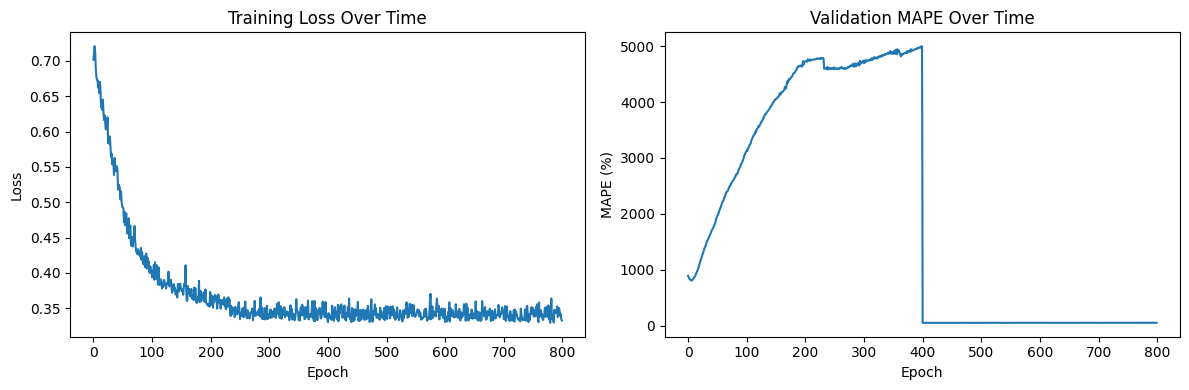

In [125]:
plt.figure(figsize=(12, 4))

# training loss
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# validation MAPE
plt.subplot(1, 2, 2)
plt.plot(val_mapes)
plt.title('Validation MAPE Over Time')
plt.xlabel('Epoch')
plt.ylabel('MAPE (%)')

plt.tight_layout()
plt.show()

In [127]:
final_model.eval()
test_predictions = []
test_actuals = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = final_model(X_batch)
        test_predictions.extend(outputs.numpy())
        test_actuals.extend(y_batch.numpy())

test_mape = mean_absolute_percentage_error(test_actuals, test_predictions) 
print(f"\nFinal Test MAPE: {test_mape:.2f}%")


Final Test MAPE: 23.59%


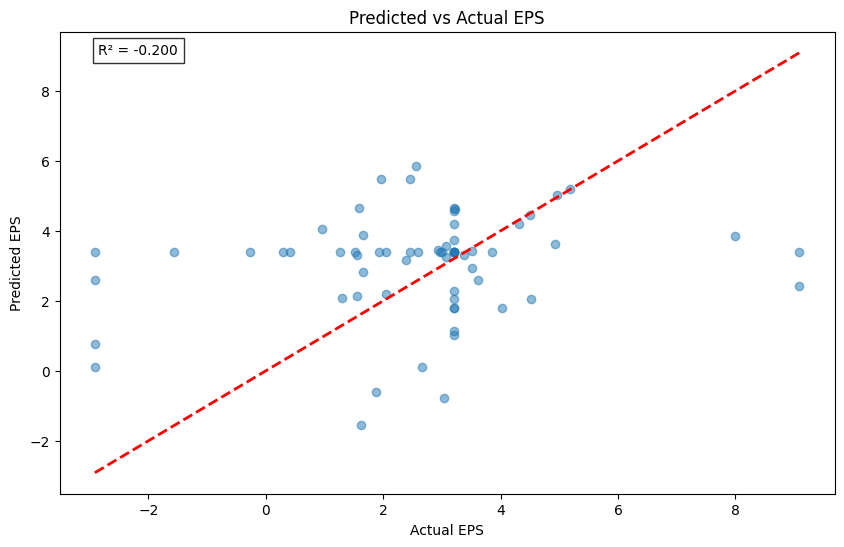

In [128]:

test_predictions = scaler_y.inverse_transform(np.array(test_predictions).reshape(-1, 1))
test_actuals = scaler_y.inverse_transform(np.array(test_actuals).reshape(-1, 1))

plt.figure(figsize=(10, 6))
plt.scatter(test_actuals, test_predictions, alpha=0.5)
plt.plot([test_actuals.min(), test_actuals.max()], 
         [test_actuals.min(), test_actuals.max()], 
         'r--', lw=2)
plt.xlabel('Actual EPS')
plt.ylabel('Predicted EPS')
plt.title('Predicted vs Actual EPS')

# Add R-squared value
from sklearn.metrics import r2_score
r2 = r2_score(test_actuals, test_predictions)
plt.text(0.05, 0.95, f'R² = {r2:.3f}', 
         transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', alpha=0.8))

plt.show()

## Problem 3: CNN-LSTM for Predicting Stock Price Prediction

In this problem, we will be using one type of combined architecture, CNN-LSTM, to predict household power consumption from historical power consumption. The data is provided in "household_power_consumption" where we will be interested in only "Global_active_power" column. In this dataset, measurements of electric power consumption in one household with a one-minute sampling rate over a period of almost 4 years. 

Different than single-time step prediction, we are now interested in predicting 60 time points (1 hour) from 600 time points (10 hours). Note that you need to carefully tune the learning rate and number of epochs. 

In [3]:
df = pd.read_csv('household_power_consumption.txt', sep=';', 
                 parse_dates={'datetime': ['Date', 'Time']}, 
                 dayfirst=True)

/var/folders/kv/563b5k8n4xg24_t9kd2d72c40000gn/T/ipykernel_1185/1235684292.py:1: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv('household_power_consumption.txt', sep=';',
/var/folders/kv/563b5k8n4xg24_t9kd2d72c40000gn/T/ipykernel_1185/1235684292.py:1: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('household_power_consumption.txt', sep=';',


In [4]:
df.set_index('datetime', inplace=True)

In [5]:
print("Dataset shape:", df.shape)

Dataset shape: (2075259, 7)


In [6]:
print("\nFirst few rows:")
print(df.head())


First few rows:
                    Global_active_power Global_reactive_power  Voltage  \
datetime                                                                 
2006-12-16 17:24:00               4.216                 0.418  234.840   
2006-12-16 17:25:00               5.360                 0.436  233.630   
2006-12-16 17:26:00               5.374                 0.498  233.290   
2006-12-16 17:27:00               5.388                 0.502  233.740   
2006-12-16 17:28:00               3.666                 0.528  235.680   

                    Global_intensity Sub_metering_1 Sub_metering_2  \
datetime                                                             
2006-12-16 17:24:00           18.400          0.000          1.000   
2006-12-16 17:25:00           23.000          0.000          1.000   
2006-12-16 17:26:00           23.000          0.000          2.000   
2006-12-16 17:27:00           23.000          0.000          1.000   
2006-12-16 17:28:00           15.800        

In [7]:
print("\nMissing values:")
print(df.isnull().sum())


Missing values:
Global_active_power          0
Global_reactive_power        0
Voltage                      0
Global_intensity             0
Sub_metering_1               0
Sub_metering_2               0
Sub_metering_3           25979
dtype: int64


In [54]:
total_rows = len(df)
sample_size = 20000
df_sampled = df.iloc[:sample_size]  # get first 10k of the data because it is too big

print("Original dataset size:", total_rows)
print("Sampled dataset size:", len(df_sampled))

Original dataset size: 2075259
Sampled dataset size: 20000


In [56]:
def create_sequences(data, input_length=600, output_length=60):
    X, y = [], []
    for i in range(len(data) - input_length - output_length + 1):
        X.append(data[i:(i + input_length)])
        y.append(data[(i + input_length):(i + input_length + output_length)])
    return np.array(X), np.array(y)

In [57]:
print("Column names:", df.columns.tolist())
print("\nSample of raw data:")
print(df.head())

Column names: ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

Sample of raw data:
                    Global_active_power Global_reactive_power  Voltage  \
datetime                                                                 
2006-12-16 17:24:00               4.216                 0.418  234.840   
2006-12-16 17:25:00               5.360                 0.436  233.630   
2006-12-16 17:26:00               5.374                 0.498  233.290   
2006-12-16 17:27:00               5.388                 0.502  233.740   
2006-12-16 17:28:00               3.666                 0.528  235.680   

                    Global_intensity Sub_metering_1 Sub_metering_2  \
datetime                                                             
2006-12-16 17:24:00           18.400          0.000          1.000   
2006-12-16 17:25:00           23.000          0.000          1.000   
2006-12-16 17:26:00           23

In [58]:
def prepare_data(df, input_length=600, output_length=60):
    df_copy = df.copy()
    
    # I got warning without using a copy
    df_copy.loc[:, 'Global_active_power'] = df_copy['Global_active_power'].replace('?', np.nan)
    data = df_copy['Global_active_power'].astype(float)
    
    data = data.ffill()  # method is deprecated so direct usage
    data = data.bfill()
    
    print("Data shape after preprocessing:", data.shape)
    print("Any missing values?", data.isnull().any())
    print("Value range:", data.min(), "-", data.max())
    
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data.values.reshape(-1, 1))
    
    X, y = [], []
    for i in range(len(data_scaled) - input_length - output_length + 1):
        X.append(data_scaled[i:(i + input_length)])
        y.append(data_scaled[(i + input_length):(i + input_length + output_length)])
    
    X = np.array(X)
    y = np.array(y)
    
    # (samples, sequence_length, features)
    X = X.reshape(X.shape[0], X.shape[1], 1)
    #  (samples, output_length)
    y = y.reshape(y.shape[0], output_length)

    print("\nSequence shapes:")
    print("X shape (samples, sequence_length, features):", X.shape)
    print("y shape (samples, output_length):", y.shape)
    
    return X, y, scaler

In [59]:
X, y, scaler = prepare_data(df_sampled)

Data shape after preprocessing: (20000,)
Any missing values? False
Value range: 0.194 - 9.132

Sequence shapes:
X shape (samples, sequence_length, features): (19341, 600, 1)
y shape (samples, output_length): (19341, 60)


In [60]:
class PowerConsumptionDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [21]:
class CNNLSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1, output_size=60):
        super(CNNLSTMModel, self).__init__()
        
        # CNN layers
        self.conv1 = nn.Conv1d(in_channels=input_size, 
                              out_channels=32, 
                              kernel_size=3,
                              padding=1)
        self.conv2 = nn.Conv1d(in_channels=32,
                              out_channels=32,
                              kernel_size=3,
                              padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(kernel_size=2)
        
        # LSTM layers
        self.lstm = nn.LSTM(input_size=32,
                           hidden_size=hidden_size,
                           num_layers=num_layers,
                           batch_first=True)
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # x shape: (batch_size, sequence_length, input_size)
        batch_size = x.size(0)
        
        # for CNN: (batch_size, input_size, sequence_length)
        x = x.transpose(1, 2)
    
        x = self.relu(self.conv1(x))
        x = self.maxpool(x)
        x = self.relu(self.conv2(x))
        x = self.maxpool(x)
        
        # for LSTM: (batch_size, sequence_length, features)
        x = x.transpose(1, 2)
    
        lstm_out, _ = self.lstm(x)
        
        # prediction
        out = self.fc(lstm_out[:, -1, :])
        return out

In [70]:
class CNNLSTMModelNew(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=2, output_size=60):
        super(CNNLSTMModelNew, self).__init__()
    
        self.conv1 = nn.Conv1d(input_size, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(64, 32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(kernel_size=2)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64)
        
        self.lstm = nn.LSTM(input_size=32,
                           hidden_size=hidden_size,
                           num_layers=num_layers,
                           batch_first=True)

        self.fc1 = nn.Linear(hidden_size, hidden_size//2)
        self.fc2 = nn.Linear(hidden_size//2, output_size)
    
    def forward(self, x):
        # x shape: (batch_size, sequence_length, input_size)
        x = x.transpose(1, 2)

        x = self.relu(self.conv1(x))
        x = self.batchnorm1(x)
        x = self.maxpool(x)
        
        x = self.relu(self.conv2(x))
        x = self.batchnorm2(x)
        x = self.maxpool(x)
        
        x = self.relu(self.conv3(x))
        x = self.maxpool(x)
        
        x = x.transpose(1, 2)
        
        lstm_out, _ = self.lstm(x)
        
        x = self.relu(self.fc1(lstm_out[:, -1, :]))
        x = self.fc2(x)
        
        return x

In [71]:
from sklearn.model_selection import train_test_split
# train,test,validation
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [72]:
# convert tensors so can convert easiy to Dataloader
train_dataset = PowerConsumptionDataset(X_train, y_train)
val_dataset = PowerConsumptionDataset(X_val, y_val)
test_dataset = PowerConsumptionDataset(X_test, y_test)

In [73]:
batch_size = 64 
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [74]:
model = CNNLSTMModelNew()
criterion = nn.MSELoss()
learning_rate = 0.0001  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)
num_epochs = 50

In [75]:
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {avg_train_loss:.4f}, '
              f'Val Loss: {avg_val_loss:.4f}')

Epoch [5/50], Train Loss: 0.0102, Val Loss: 0.0097
Epoch [10/50], Train Loss: 0.0076, Val Loss: 0.0077
Epoch [15/50], Train Loss: 0.0065, Val Loss: 0.0063
Epoch [20/50], Train Loss: 0.0054, Val Loss: 0.0052
Epoch [25/50], Train Loss: 0.0048, Val Loss: 0.0048
Epoch [30/50], Train Loss: 0.0044, Val Loss: 0.0044
Epoch [35/50], Train Loss: 0.0042, Val Loss: 0.0042
Epoch [40/50], Train Loss: 0.0039, Val Loss: 0.0040
Epoch [45/50], Train Loss: 0.0037, Val Loss: 0.0038
Epoch [50/50], Train Loss: 0.0036, Val Loss: 0.0036


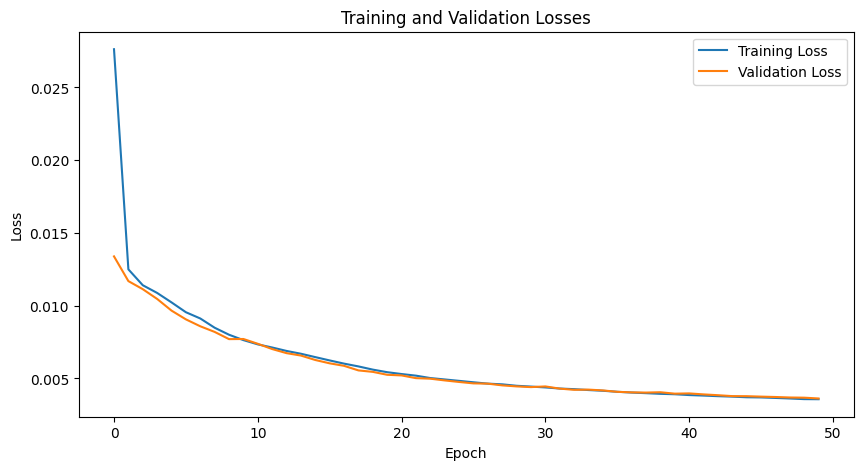

In [76]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [77]:
# test set predictions
# Modified evaluation code
model.eval()
test_mse_scaled = 0  # MSE on scaled data
test_mse_original = 0  # MSE on original scale data
num_batches = 0

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        # Get predictions
        test_pred = model(X_batch)
        
        # Calculate MSE on scaled data
        test_mse_scaled += nn.MSELoss()(test_pred, y_batch).item()
        
        # Calculate MSE on original scale
        pred_orig = scaler.inverse_transform(test_pred.numpy().reshape(-1, test_pred.shape[1]))
        y_orig = scaler.inverse_transform(y_batch.numpy().reshape(-1, y_batch.shape[1]))
        test_mse_original += np.mean((pred_orig - y_orig) ** 2)
        
        num_batches += 1

avg_mse_scaled = test_mse_scaled / num_batches
avg_mse_original = test_mse_original / num_batches

print(f'Test MSE (scaled data): {avg_mse_scaled:.4f}')
print(f'Test MSE (original scale): {avg_mse_original:.4f}')


Test MSE (scaled data): 0.0037
Test MSE (original scale): 0.2943


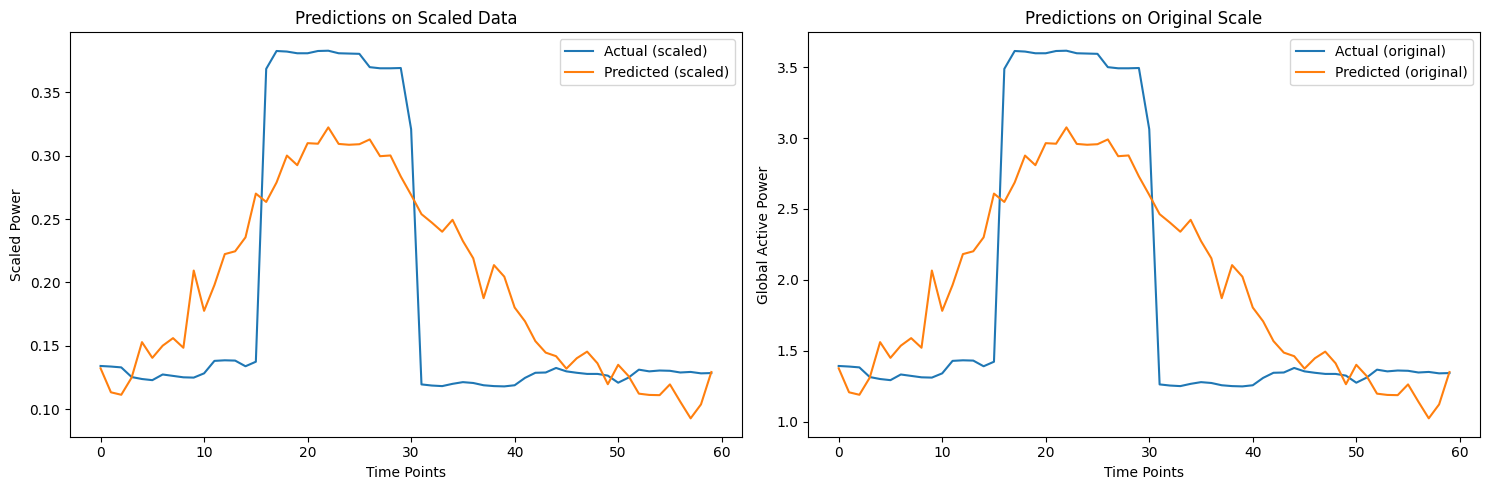

In [78]:
# Plot scaled predictions
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(y_batch[0].numpy(), label='Actual (scaled)')
plt.plot(test_pred[0].numpy(), label='Predicted (scaled)')
plt.title('Predictions on Scaled Data')
plt.xlabel('Time Points')
plt.ylabel('Scaled Power')
plt.legend()

# Plot original scale predictions
plt.subplot(1, 2, 2)
plt.plot(y_orig[0], label='Actual (original)')
plt.plot(pred_orig[0], label='Predicted (original)')
plt.title('Predictions on Original Scale')
plt.xlabel('Time Points')
plt.ylabel('Global Active Power')
plt.legend()

plt.tight_layout()
plt.show()

### Train with lower number of epoch for comparison 

In [87]:
model = CNNLSTMModelNew()
criterion = nn.MSELoss()
learning_rate = 0.0001  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)
num_epochs = 5

In [89]:
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    if (epoch + 1) % 1 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {avg_train_loss:.4f}, '
              f'Val Loss: {avg_val_loss:.4f}')

Epoch [1/5], Train Loss: 0.0138, Val Loss: 0.0122
Epoch [2/5], Train Loss: 0.0119, Val Loss: 0.0114
Epoch [3/5], Train Loss: 0.0113, Val Loss: 0.0110
Epoch [4/5], Train Loss: 0.0108, Val Loss: 0.0105
Epoch [5/5], Train Loss: 0.0105, Val Loss: 0.0102


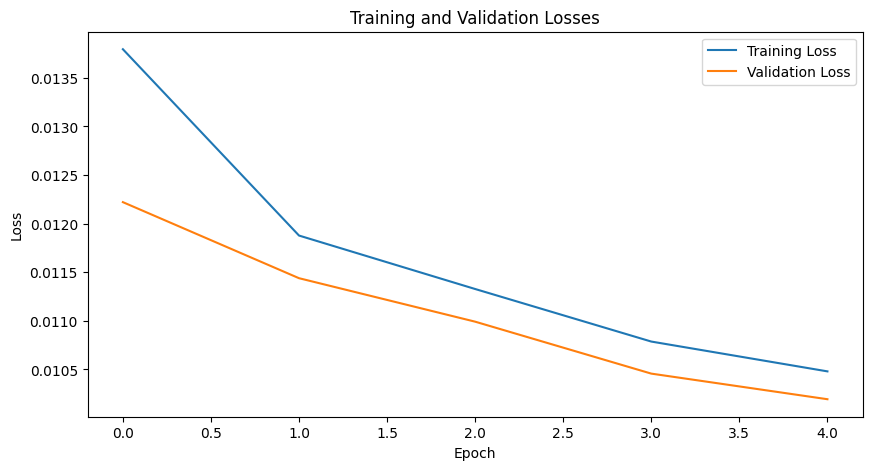

In [90]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [91]:
# test set predictions
# Modified evaluation code
model.eval()
test_mse_scaled = 0  # MSE on scaled data
test_mse_original = 0  # MSE on original scale data
num_batches = 0

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        # Get predictions
        test_pred = model(X_batch)
        
        # Calculate MSE on scaled data
        test_mse_scaled += nn.MSELoss()(test_pred, y_batch).item()
        
        # Calculate MSE on original scale
        pred_orig = scaler.inverse_transform(test_pred.numpy().reshape(-1, test_pred.shape[1]))
        y_orig = scaler.inverse_transform(y_batch.numpy().reshape(-1, y_batch.shape[1]))
        test_mse_original += np.mean((pred_orig - y_orig) ** 2)
        
        num_batches += 1

avg_mse_scaled = test_mse_scaled / num_batches
avg_mse_original = test_mse_original / num_batches

print(f'Test MSE (scaled data): {avg_mse_scaled:.4f}')
print(f'Test MSE (original scale): {avg_mse_original:.4f}')

Test MSE (scaled data): 0.0104
Test MSE (original scale): 0.8275


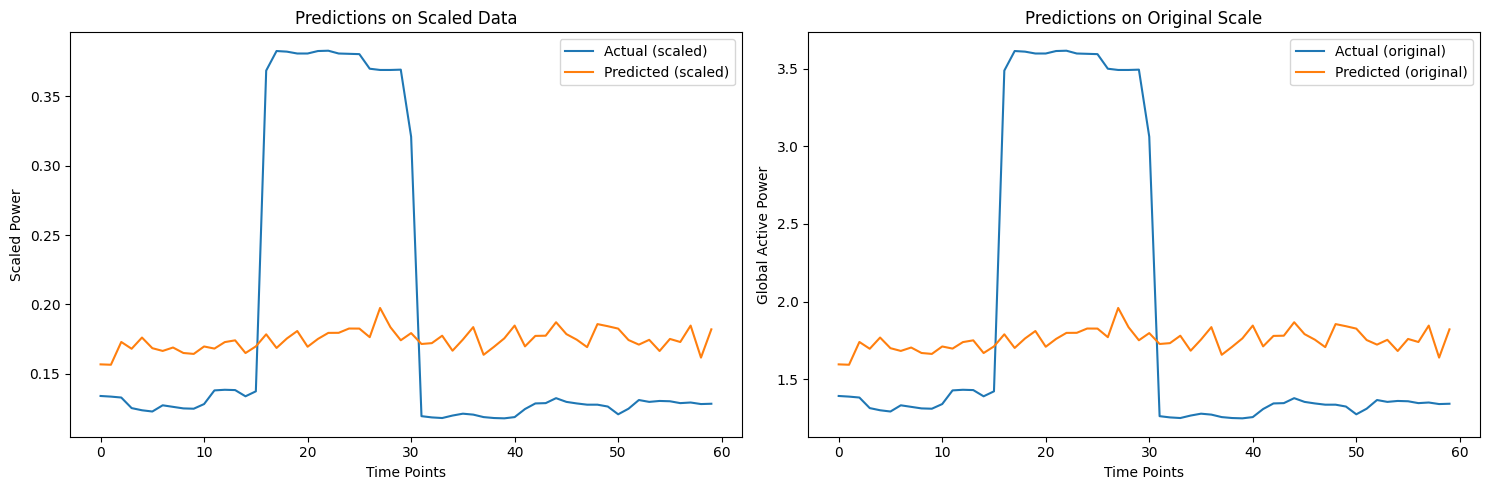

In [92]:
# Plot scaled predictions
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(y_batch[0].numpy(), label='Actual (scaled)')
plt.plot(test_pred[0].numpy(), label='Predicted (scaled)')
plt.title('Predictions on Scaled Data')
plt.xlabel('Time Points')
plt.ylabel('Scaled Power')
plt.legend()

# Plot original scale predictions
plt.subplot(1, 2, 2)
plt.plot(y_orig[0], label='Actual (original)')
plt.plot(pred_orig[0], label='Predicted (original)')
plt.title('Predictions on Original Scale')
plt.xlabel('Time Points')
plt.ylabel('Global Active Power')
plt.legend()

plt.tight_layout()
plt.show()